In [ ]:
import time
import threading
import uuid
import random
import psutil
from queue import Queue

# 儲存執行緒狀態的字典
thread_status = {}

# 任務隊列
job_queue = Queue()

# 全局變數追蹤系統數據
total_jobs_in_hour = 0
hour_start_time = time.time()
fixed_thread_count = 8  # 固定執行緒數量

# 產生執行緒 (每 5 分鐘觸發)
def add_jobs():
    global total_jobs_in_hour, hour_start_time

    while True:
        current_time = time.time()

        # 檢查是否進入新的小時
        if current_time - hour_start_time > 3600:
            total_jobs_in_hour = 0
            hour_start_time = current_time
            print(f"[{time.strftime('%H:%M:%S')}] 新的小時開始，重置任務計數")

        # 產生1-20個執行緒 (符合條件1)
        num_jobs = random.randint(1, 20)

        # 確保每小時總量不超過200
        remaining_jobs = 200 - total_jobs_in_hour
        if num_jobs > remaining_jobs:
            num_jobs = remaining_jobs

        # 如果已達到小時限制，則不生成新任務
        if num_jobs <= 0:
            print(f"[{time.strftime('%H:%M:%S')}] 已達到小時限制200個任務，本次不產生新任務")
            time.sleep(300)  # 5分鐘後再次檢查
            continue

        # 生成任務
        for _ in range(num_jobs):
            job_id = str(uuid.uuid4())
            job_queue.put(job_id)
            thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": current_time,
                "creation_time": time.strftime('%H:%M:%S')
            }

        total_jobs_in_hour += num_jobs

        print(f"[{time.strftime('%H:%M:%S')}] 加入 {num_jobs} 個執行緒到佇列 "
              f"(本小時已生成: {total_jobs_in_hour}/200)")

        # 等待5分鐘後再次生成 (符合條件1)
        time.sleep(300)

# 執行緒處理函數
def process_thread(job_id):
    current_time = time.time()

    # 更新狀態為執行中
    if job_id in thread_status:
        thread_status[job_id]["state"] = "RUNNING"
        thread_status[job_id]["start_time"] = current_time
        thread_status[job_id]["start_time_str"] = time.strftime('%H:%M:%S')

    print(f"[{time.strftime('%H:%M:%S')}] 執行執行緒 {job_id}")

    # 模擬執行 20 秒 (符合條件2)
    time.sleep(20)

    # 更新狀態為已完成
    thread_status[job_id]["state"] = "COMPLETED"
    thread_status[job_id]["completion_time"] = time.time()
    thread_status[job_id]["completion_time_str"] = time.strftime('%H:%M:%S')

    # 計算執行時間
    execution_time = thread_status[job_id]["completion_time"] - thread_status[job_id]["start_time"]
    thread_status[job_id]["execution_time"] = execution_time

    # 計算等待時間
    wait_time = thread_status[job_id]["start_time"] - thread_status[job_id]["queue_time"]
    thread_status[job_id]["wait_time"] = wait_time

    print(f"[{time.strftime('%H:%M:%S')}] 完成執行緒 {job_id} (執行時間: {execution_time:.2f}秒, 等待時間: {wait_time:.2f}秒)")

# 簡單實作條件3 - 檢查未完成的任務並重新排程
def check_unfinished_tasks():
    while True:
        time.sleep(300)  # 每5分鐘檢查一次 (符合條件3)

        # 只重新排程PENDING狀態的任務，不進行優先級調整
        for job_id, status in list(thread_status.items()):
            if status["state"] == "PENDING":
                # 不執行任何優先級調整，只放回隊列確保最終會被處理
                if job_id in job_queue.queue:
                    # 已在隊列中，不重複添加
                    continue
                else:
                    # 重新加入隊列
                    job_queue.put(job_id)
                    print(f"[{time.strftime('%H:%M:%S')}] 未完成任務 {job_id} 重新排入隊列")

# 簡單監控
def simple_monitor():
    while True:
        time.sleep(60)  # 每分鐘監控一次

        # 計算各狀態的任務數
        completed = sum(1 for v in thread_status.values() if v["state"] == "COMPLETED")
        pending = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
        running = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

        # 計算平均等待和執行時間
        wait_times = [v.get("wait_time", 0) for v in thread_status.values() if v.get("wait_time") is not None]
        exec_times = [v.get("execution_time", 0) for v in thread_status.values() if v.get("execution_time") is not None]

        avg_wait = sum(wait_times) / len(wait_times) if wait_times else 0
        max_wait = max(wait_times) if wait_times else 0

        print(f"[{time.strftime('%H:%M:%S')}] 監控報告: 執行中 {running} / 等待中 {pending} / 完成 {completed}")
        print(f"[{time.strftime('%H:%M:%S')}] 平均等待時間: {avg_wait:.2f}秒, 最大等待時間: {max_wait:.2f}秒")
        print(f"[{time.strftime('%H:%M:%S')}] 佇列中任務數量: {job_queue.qsize()}")
        print(f"[{time.strftime('%H:%M:%S')}] 本小時已產生任務: {total_jobs_in_hour}/200")

# 啟動固定大小的執行緒池
def run_fixed_thread_pool():
    while True:
        # 從隊列獲取任務並處理
        if not job_queue.empty():
            job_id = job_queue.get()

            # 檢查是否已經處理過
            if job_id in thread_status and thread_status[job_id]["state"] == "COMPLETED":
                continue

            # 檢查執行緒池是否已達上限
            running_count = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

            if running_count < fixed_thread_count:
                # 有可用執行緒，立即處理
                thread = threading.Thread(target=process_thread, args=(job_id,))
                thread.daemon = True
                thread.start()
            else:
                # 無可用執行緒，放回隊列
                job_queue.put(job_id)
                time.sleep(0.5)  # 避免快速循環
        else:
            # 無任務時短暫暫停
            time.sleep(0.5)

# 主函數
def main():
    # 啟動管理執行緒
    threading.Thread(target=add_jobs, daemon=True).start()
    threading.Thread(target=run_fixed_thread_pool, daemon=True).start()
    threading.Thread(target=simple_monitor, daemon=True).start()
    threading.Thread(target=check_unfinished_tasks, daemon=True).start()

    print(f"[{time.strftime('%H:%M:%S')}] 系統已啟動 (固定執行緒數: {fixed_thread_count})")

    try:
        # 主執行緒保持活動以防止程式結束
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print(f"[{time.strftime('%H:%M:%S')}] 系統正在關閉...")

if __name__ == "__main__":
    main()

[08:00:49] 加入 1 個執行緒到佇列 (本小時已生成: 1/200)
[08:00:49] 執行執行緒 076c25dc-6ff5-44a9-bbcc-b5c56ed77bae
[08:00:49] 系統已啟動 (固定執行緒數: 8)
[08:01:09] 完成執行緒 076c25dc-6ff5-44a9-bbcc-b5c56ed77bae (執行時間: 20.00秒, 等待時間: 0.00秒)
[08:01:27] 監控報告: 執行中 0 / 等待中 0 / 完成 1
[08:01:27] 佇列中任務數量: 0
[08:01:27] 本小時已產生任務: 1/200
[08:01:49] 監控報告: 執行中 0 / 等待中 0 / 完成 1
[08:01:49] 平均等待時間: 0.00秒, 最大等待時間: 0.00秒
[08:01:49] 佇列中任務數量: 0
[08:01:49] 本小時已產生任務: 1/200
[08:02:27] 監控報告: 執行中 0 / 等待中 0 / 完成 1
[08:02:27] 佇列中任務數量: 0
[08:02:27] 本小時已產生任務: 1/200
[08:02:49] 監控報告: 執行中 0 / 等待中 0 / 完成 1
[08:02:49] 平均等待時間: 0.00秒, 最大等待時間: 0.00秒
[08:02:49] 佇列中任務數量: 0
[08:02:49] 本小時已產生任務: 1/200
[08:03:27] 加入 4 個執行緒到佇列 (本小時已生成: 5)
[08:03:27] 監控報告: 執行中 0 / 等待中 4 / 完成 1
[08:03:27] 佇列中任務數量: 4
[08:03:27] 本小時已產生任務: 5/200
[08:03:27] 執行執行緒 4cd81195-f711-41c9-8fd9-5f0199744dc0
[08:03:27] 執行執行緒 3cc27082-0211-4e40-b034-ce8d06920d12
[08:03:27] 執行執行緒 b6a6c34a-9e13-49a2-adab-2a93282af91f
[08:03:27] 執行執行緒 ce453606-941f-40e5-9e5f-0a0beb1f491d
[08:03:47] 完成執行緒 4cd81195-f7

分析結果

初始化基本系統模擬器 (模擬時長: 24小時)
開始執行模擬 (總時長: 24小時)
模擬進度: 5.0% (模擬時間: 01:12:00)
模擬進度: 10.0% (模擬時間: 02:24:00)
模擬進度: 15.0% (模擬時間: 03:36:00)
模擬進度: 20.0% (模擬時間: 04:48:00)
模擬進度: 25.0% (模擬時間: 06:00:00)
模擬進度: 30.0% (模擬時間: 07:12:00)
模擬進度: 35.0% (模擬時間: 08:24:00)
模擬進度: 40.0% (模擬時間: 09:36:00)
模擬進度: 45.0% (模擬時間: 10:48:00)
模擬進度: 50.0% (模擬時間: 12:00:00)
模擬進度: 55.0% (模擬時間: 13:12:00)
模擬進度: 60.0% (模擬時間: 14:24:00)
模擬進度: 65.0% (模擬時間: 15:36:00)
模擬進度: 70.0% (模擬時間: 16:48:00)
模擬進度: 75.0% (模擬時間: 18:00:00)
模擬進度: 80.0% (模擬時間: 19:12:00)
模擬進度: 85.0% (模擬時間: 20:24:00)
模擬進度: 90.0% (模擬時間: 21:36:00)
模擬進度: 95.0% (模擬時間: 22:48:00)
模擬完成 (實際執行時間: 34.38秒)

 基本系統模擬結果摘要

效能指標:
平均等待時間: 8.44秒
最大等待時間: 42.00秒
中位數等待時間: 0.00秒
95%分位等待時間: 21.00秒
平均響應時間: 28.44秒
每小時任務處理量: 121.12個/小時
平均佇列長度: 0.28
最大佇列長度: 12
執行緒利用率: 8.41%

任務統計:
總任務數: 2907
完成任務數: 2907
任務完成率: 100.00%

等待時間分布:
0-30秒: 95.49%
30-60秒: 4.51%
60-120秒: 0.00%
120-300秒: 0.00%
300+秒: 0.00%



<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 25836 (\N{CJK UNIFIED IDEOGRAPH-64EC}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-ca0419fa47be>:302: UserWarning: Glyph 20295 (\N{CJK UNIFIED IDEOGRAPH-4F4

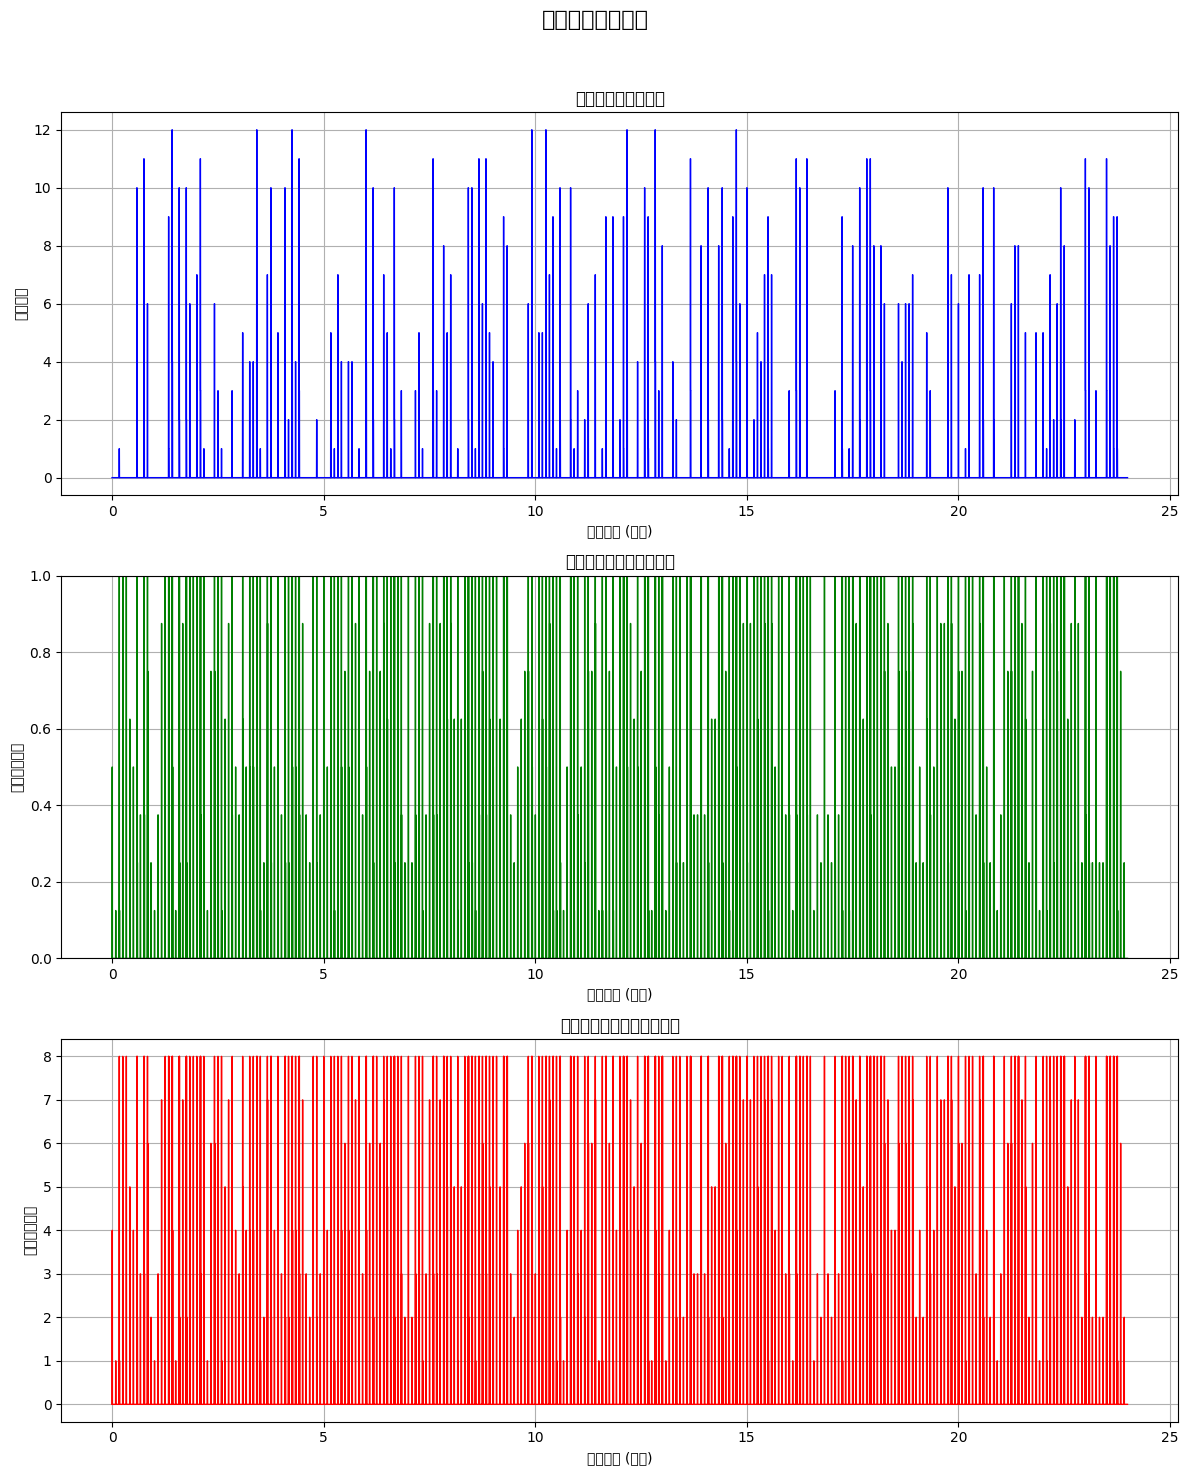

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21209 (\N{CJK UNIFIED IDEOGRAPH-52D9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas

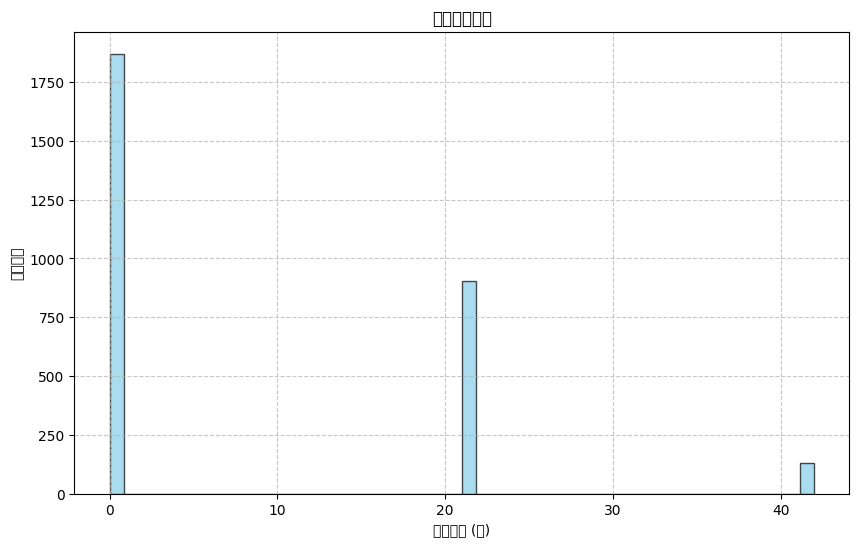

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


模擬器執行完成，結果已保存為 'basic_system_results.pkl'


In [1]:
# 在此處添加模擬器程式碼
# 這部分應該在原始系統程式碼之後

import time
import statistics
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display

class SystemSimulator:
    def __init__(self, is_optimized=True, simulation_hours=24, random_seed=42):
        self.is_optimized = is_optimized
        self.simulation_hours = simulation_hours
        self.current_time = 0  # 模擬時間（秒）
        self.thread_status = {}
        self.job_queue = []
        self.completed_jobs = []
        self.thread_count = 8  # 初始/固定執行緒數
        self.total_jobs_in_hour = 0
        self.hour_start_time = 0
        self.job_arrival_history = []

        # 設置隨機種子確保結果可重複
        random.seed(random_seed)

        # 統計數據
        self.wait_times = []
        self.response_times = []
        self.thread_utilization = []
        self.queue_lengths = []
        self.active_threads = []
        self.time_records = []

        # 模擬不同負載的時段
        self.peak_hours = [7, 8, 9, 12, 13, 17, 18]  # 尖峰時段

        print(f"初始化{'優化' if is_optimized else '基本'}系統模擬器 (模擬時長: {simulation_hours}小時)")

    def get_thread_count(self):
        """計算當前應使用的執行緒數量"""
        if not self.is_optimized:
            return self.thread_count

        # 簡化的Little's Law實現
        # 計算最近一小時內的到達率
        recent_arrivals = [job for job, t in self.job_arrival_history
                           if t > self.current_time - 3600]

        if not recent_arrivals or self.current_time == 0:
            return self.thread_count

        arrival_rate = len(recent_arrivals) / max(1, min(3600, self.current_time))
        service_time = 20  # 固定服務時間

        # Little's Law: L = λW
        optimal_threads = max(3, min(20, int(arrival_rate * service_time)))

        # 考慮當前時段是否為尖峰時段
        current_hour = (self.current_time // 3600) % 24
        is_peak_hour = current_hour in self.peak_hours

        # 在尖峰時段增加執行緒數
        if is_peak_hour and self.is_optimized:
            optimal_threads = min(20, int(optimal_threads * 1.5))

        return optimal_threads

    def generate_jobs(self):
        """產生新任務"""
        # 檢查是否進入新的小時
        current_hour = self.current_time // 3600
        if current_hour > self.hour_start_time // 3600:
            self.total_jobs_in_hour = 0
            self.hour_start_time = current_hour * 3600

        # 確定產生任務數量
        if self.is_optimized:
            # 考慮當前佇列大小和系統負載
            queue_size = len(self.job_queue)
            running_jobs = sum(1 for job in self.thread_status.values()
                               if job["state"] == "RUNNING")

            # 計算系統負載因子
            current_thread_count = self.get_thread_count()
            load_factor = (running_jobs + queue_size) / max(1, current_thread_count)

            # 根據負載調整產生數量
            if load_factor > 1.2:  # 負載很高
                num_jobs = random.randint(1, 5)
            elif load_factor < 0.3:  # 負載很低
                num_jobs = random.randint(15, 20)
            else:  # 負載適中
                num_jobs = random.randint(5, 15)
        else:
            # 簡單版本：固定隨機數 (1-20)
            num_jobs = random.randint(1, 20)

        # 確保不超過每小時限制
        remaining_jobs = 200 - self.total_jobs_in_hour
        num_jobs = min(num_jobs, remaining_jobs)

        # 產生任務
        for _ in range(num_jobs):
            job_id = f"job_{len(self.thread_status)}"
            self.job_queue.append(job_id)
            self.thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": self.current_time,
                "creation_time": self.current_time
            }
            self.job_arrival_history.append((job_id, self.current_time))

        self.total_jobs_in_hour += num_jobs
        return num_jobs

    def check_unfinished_tasks(self):
        """檢查未完成的任務並重新排程 (符合條件3)"""
        if self.current_time % 300 != 0:  # 每5分鐘檢查一次
            return

        rescheduled_count = 0

        for job_id in list(self.job_queue):
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                # 計算等待時間
                wait_time = self.current_time - self.thread_status[job_id]["queue_time"]

                # 如果使用優化系統，長時間等待的任務會被提高優先級
                if self.is_optimized and wait_time > 300:  # 等待超過5分鐘
                    self.job_queue.remove(job_id)
                    self.job_queue.insert(0, job_id)  # 放到佇列前端
                    rescheduled_count += 1

        if rescheduled_count > 0 and self.is_optimized:
            print(f"[{self.format_time(self.current_time)}] 重新排程了 {rescheduled_count} 個長時間等待的任務")

    def process_jobs(self):
        """處理佇列中的任務"""
        current_thread_count = self.get_thread_count()
        running_jobs = sum(1 for job in self.thread_status.values()
                          if job["state"] == "RUNNING")

        # 記錄執行緒利用率
        self.thread_utilization.append(running_jobs / max(1, current_thread_count))
        self.active_threads.append(running_jobs)

        # 處理已完成的任務
        for job_id, status in list(self.thread_status.items()):
            if status["state"] == "RUNNING":
                if self.current_time >= status["start_time"] + 20:  # 任務完成 (20秒)
                    status["state"] = "COMPLETED"
                    status["completion_time"] = self.current_time

                    # 計算等待和響應時間
                    wait_time = status["start_time"] - status["queue_time"]
                    response_time = status["completion_time"] - status["queue_time"]

                    status["wait_time"] = wait_time
                    status["response_time"] = response_time

                    self.wait_times.append(wait_time)
                    self.response_times.append(response_time)
                    self.completed_jobs.append(job_id)

        # 檢查是否需要重新排程長等待任務
        self.check_unfinished_tasks()

        # 啟動新任務
        available_threads = current_thread_count - running_jobs
        for _ in range(min(available_threads, len(self.job_queue))):
            if not self.job_queue:
                break

            job_id = self.job_queue.pop(0)
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                self.thread_status[job_id]["state"] = "RUNNING"
                self.thread_status[job_id]["start_time"] = self.current_time

    def format_time(self, seconds):
        """將秒數格式化為時:分:秒"""
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        secs = seconds % 60
        return f"{hours:02d}:{minutes:02d}:{secs:02d}"

    def run_simulation(self):
        """執行模擬"""
        total_simulation_time = self.simulation_hours * 3600  # 轉換為秒

        print(f"開始執行模擬 (總時長: {self.simulation_hours}小時)")
        simulation_start = time.time()  # 記錄實際執行時間

        progress_interval = total_simulation_time // 20  # 顯示20次進度
        next_progress = progress_interval

        while self.current_time < total_simulation_time:
            # 每5分鐘產生新任務
            if self.current_time % 300 == 0:
                self.generate_jobs()

            # 處理任務
            self.process_jobs()

            # 記錄佇列長度
            self.queue_lengths.append(len(self.job_queue))
            self.time_records.append(self.current_time)

            # 顯示進度
            if self.current_time >= next_progress:
                percent_done = (self.current_time / total_simulation_time) * 100
                print(f"模擬進度: {percent_done:.1f}% (模擬時間: {self.format_time(self.current_time)})")
                next_progress += progress_interval

            # 時間前進
            self.current_time += 1

        simulation_time = time.time() - simulation_start
        print(f"模擬完成 (實際執行時間: {simulation_time:.2f}秒)")

        # 返回模擬結果
        return self.get_statistics()

    def get_statistics(self):
        """取得模擬統計數據"""
        if not self.wait_times:
            return {
                "avg_wait_time": 0,
                "max_wait_time": 0,
                "avg_response_time": 0,
                "throughput": 0,
                "avg_queue_length": 0,
                "max_queue_length": 0,
                "thread_utilization": 0
            }

        # 等待時間分佈分析
        wait_times_np = np.array(self.wait_times)
        wait_time_dist = {
            "0-30秒": sum(1 for t in self.wait_times if t <= 30) / len(self.wait_times) * 100,
            "30-60秒": sum(1 for t in self.wait_times if 30 < t <= 60) / len(self.wait_times) * 100,
            "60-120秒": sum(1 for t in self.wait_times if 60 < t <= 120) / len(self.wait_times) * 100,
            "120-300秒": sum(1 for t in self.wait_times if 120 < t <= 300) / len(self.wait_times) * 100,
            "300+秒": sum(1 for t in self.wait_times if t > 300) / len(self.wait_times) * 100
        }

        stats = {
            "avg_wait_time": statistics.mean(self.wait_times),
            "max_wait_time": max(self.wait_times),
            "median_wait_time": statistics.median(self.wait_times),
            "p95_wait_time": np.percentile(self.wait_times, 95),
            "avg_response_time": statistics.mean(self.response_times),
            "throughput": len(self.completed_jobs) / (self.simulation_hours * 3600) * 3600,  # 每小時
            "avg_queue_length": statistics.mean(self.queue_lengths),
            "max_queue_length": max(self.queue_lengths),
            "thread_utilization": statistics.mean(self.thread_utilization),
            "wait_time_distribution": wait_time_dist,
            "completed_jobs": len(self.completed_jobs),
            "total_jobs": len(self.thread_status),
            "completion_rate": len(self.completed_jobs) / len(self.thread_status) * 100 if len(self.thread_status) > 0 else 0
        }

        return stats

    def plot_results(self):
        """繪製模擬結果圖表"""
        if not self.time_records:
            print("沒有模擬數據可用於繪圖")
            return None

        # 轉換時間記錄為小時
        hours = [t/3600 for t in self.time_records]

        # 建立子圖
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
        fig.suptitle(f"{'優化' if self.is_optimized else '基本'}系統模擬結果", fontsize=16)

        # 佇列長度隨時間變化
        axs[0].plot(hours, self.queue_lengths, 'b-', linewidth=1)
        axs[0].set_title('佇列長度隨時間變化')
        axs[0].set_xlabel('模擬時間 (小時)')
        axs[0].set_ylabel('佇列長度')
        axs[0].grid(True)

        # 執行緒利用率隨時間變化
        axs[1].plot(hours, self.thread_utilization, 'g-', linewidth=1)
        axs[1].set_title('執行緒利用率隨時間變化')
        axs[1].set_xlabel('模擬時間 (小時)')
        axs[1].set_ylabel('執行緒利用率')
        axs[1].set_ylim(0, 1.0)
        axs[1].grid(True)

        # 活躍執行緒數量隨時間變化
        axs[2].plot(hours, self.active_threads, 'r-', linewidth=1)
        axs[2].set_title('活躍執行緒數量隨時間變化')
        axs[2].set_xlabel('模擬時間 (小時)')
        axs[2].set_ylabel('活躍執行緒數')
        axs[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題

        # 等待時間分布直方圖
        plt.figure(figsize=(10, 6))
        plt.hist(self.wait_times, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('等待時間分布')
        plt.xlabel('等待時間 (秒)')
        plt.ylabel('任務數量')
        plt.grid(True, linestyle='--', alpha=0.7)

        return fig

    def display_summary(self):
        """顯示模擬結果摘要"""
        stats = self.get_statistics()

        print("\n" + "="*50)
        print(f" {'優化' if self.is_optimized else '基本'}系統模擬結果摘要")
        print("="*50)

        print(f"\n效能指標:")
        print(f"平均等待時間: {stats['avg_wait_time']:.2f}秒")
        print(f"最大等待時間: {stats['max_wait_time']:.2f}秒")
        print(f"中位數等待時間: {stats['median_wait_time']:.2f}秒")
        print(f"95%分位等待時間: {stats['p95_wait_time']:.2f}秒")
        print(f"平均響應時間: {stats['avg_response_time']:.2f}秒")
        print(f"每小時任務處理量: {stats['throughput']:.2f}個/小時")
        print(f"平均佇列長度: {stats['avg_queue_length']:.2f}")
        print(f"最大佇列長度: {stats['max_queue_length']}")
        print(f"執行緒利用率: {stats['thread_utilization']*100:.2f}%")

        print(f"\n任務統計:")
        print(f"總任務數: {stats['total_jobs']}")
        print(f"完成任務數: {stats['completed_jobs']}")
        print(f"任務完成率: {stats['completion_rate']:.2f}%")

        print(f"\n等待時間分布:")
        for range_name, percentage in stats['wait_time_distribution'].items():
            print(f"{range_name}: {percentage:.2f}%")

        print("\n" + "="*50)

        return stats

# 創建並執行模擬器
def run_simulation(is_optimized=True, hours=24, seed=42):
    simulator = SystemSimulator(is_optimized=is_optimized, simulation_hours=hours, random_seed=seed)
    results = simulator.run_simulation()
    simulator.display_summary()

    # 繪製圖表
    simulator.plot_results()
    plt.show()

    return simulator, results

# 在此處執行模擬，這部分可以根據需要修改參數

simulator, results = run_simulation(is_optimized=False)

# 保存結果供後續比較
import pickle
with open('basic_system_results.pkl', 'wb') as f:
    pickle.dump({
        'stats': results,
        'wait_times': simulator.wait_times,
        'queue_lengths': simulator.queue_lengths,
        'thread_utilization': simulator.thread_utilization,
        'active_threads': simulator.active_threads,
        'time_records': simulator.time_records
    }, f)

# 下載結果檔案
from google.colab import files
files.download('basic_system_results.pkl')

print("\n模擬器執行完成，結果已保存為 'basic_system_results.pkl'")